<a href="https://colab.research.google.com/github/Flychuban/LipReadingApp/blob/main/lip_reading_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python imageio gdown tensorflow

In [58]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [4]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [33]:
def load_video(path: str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236, 80:220, :])
  cap.release()
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std

In [34]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [35]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), oov_token = "", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [48]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [49]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('../' + 'content', 'drive', 'MyDrive', 'LipReading', 'data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('../' + 'content', 'drive', 'MyDrive', 'LipReading', 'data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [52]:
test_path = '../content/drive/MyDrive/LipReading/data/s1/bbal6n.mpg'

In [53]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames

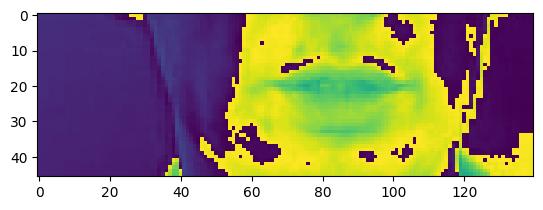

In [59]:
plt.imshow(frames[30])

In [60]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result